***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = posix
• Working Directory = /home/knoor/Downloads/RunningOnServer/HD-CapsNet_MTree/Training_and_Analysis/7_Marin_Tree
• Python Version = 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
• TensorFlow Version = 2.8.4
• Keras Version = 2.8.0
• Current Environment = Not Using Anaconda


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


2023-04-13 11:20:08.167341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 11:20:08.996056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20608 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('7_Marine_Tree/HD_CapsNet/Mod_3_3')

FOLDER CREATED =  ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3


# Import Dataset : Marine Tree Dataset

In [6]:
dataset = datasets.get_Marine_dataset(output_level='level_depth_3', # 'level_depth_3', 'level_depth_4', 'level_depth_5
#                                       dataset_path ='D:\Datasets\Marine_tree', ## Path to the dataset directory
                                      dataset_path ='/home/knoor/Downloads/RunningOnServer/H-CapsNet_Revision/Dataset/Marine_tree', ## Path to the dataset directory
                                      image_size=(64,64),
                                      batch_size=train_params['batch_size'],
                                      subtype='Combined',
                                      data_normalizing ='normalize',
                                      class_encoding = 'One_Hot_Encoder',
                                      data_augmantation = 'mixup'
                                     )

2023-04-13 11:20:27.577694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5447 of 6400
2023-04-13 11:20:28.952515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


Example =  0


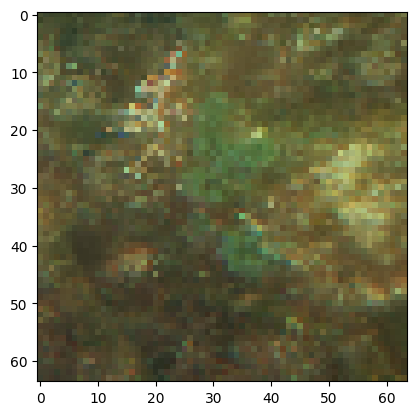

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {1: 0.8873789, 33: 0.112621106}
Example =  1


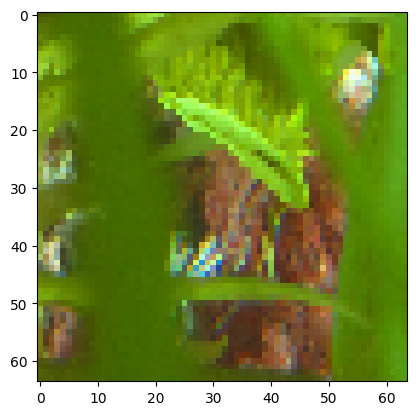

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {4: 1.0}
Example =  2


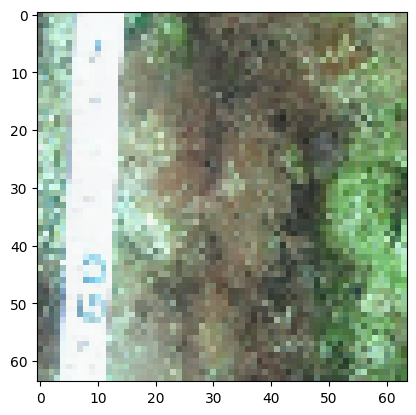

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {4: 0.961441, 10: 0.038559016}
Example =  3


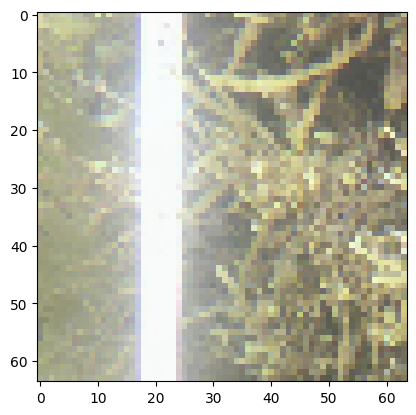

Coarse = {0: 1.0}
Medium = {0: 0.026788414, 7: 0.9732116}
Fine   = {31: 0.026788414, 33: 0.9732116}
Example =  4


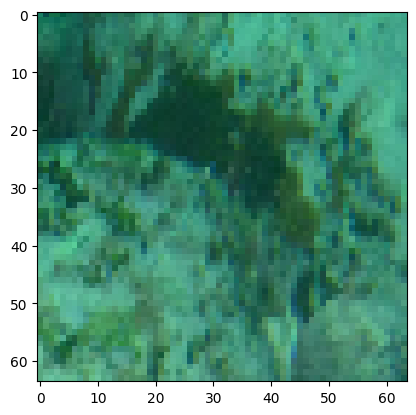

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 0.99147654, 33: 0.008523486}
Example =  5


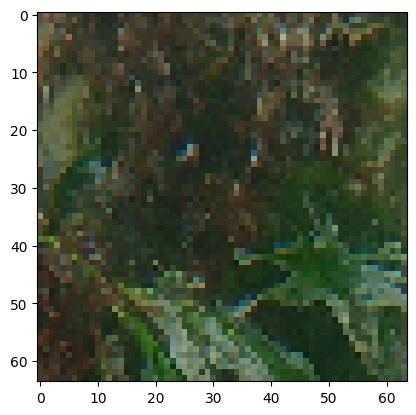

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 0.054237306, 4: 0.9457627}
Example =  6


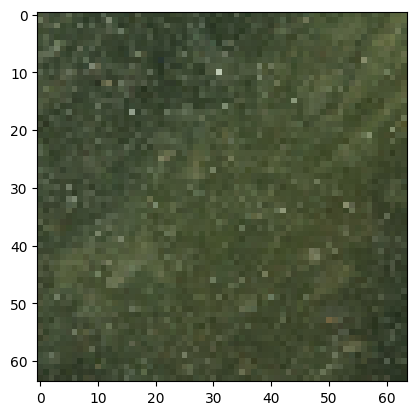

Coarse = {0: 0.9069765, 1: 0.09302348}
Medium = {7: 0.9069765, 9: 0.09302348}
Fine   = {0: 0.9069765, 14: 0.09302348}
Example =  7


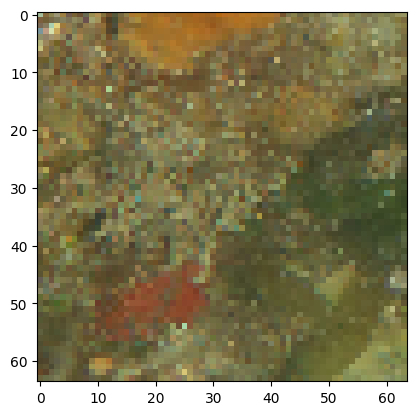

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {4: 0.9130494, 33: 0.0869506}
Example =  8


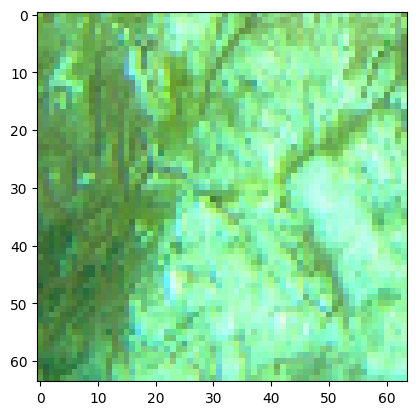

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {4: 0.9999125, 33: 8.749962e-05}
Example =  9


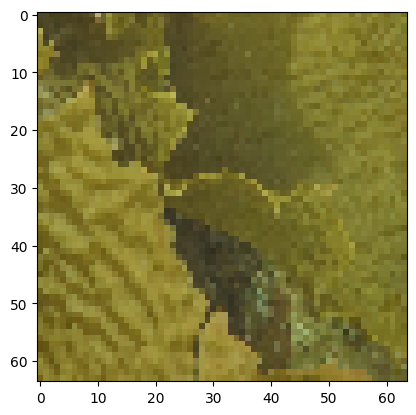

Coarse = {0: 0.8153901, 1: 0.18460989}
Medium = {7: 0.8153901, 9: 0.18460989}
Fine   = {15: 0.18460989, 33: 0.8153901}
Example =  10


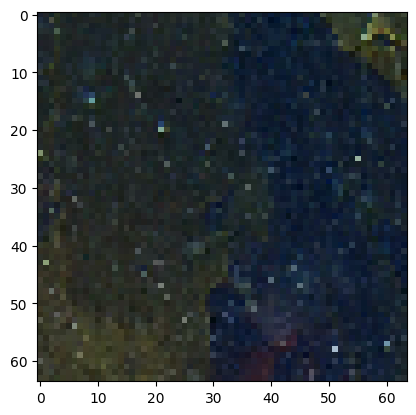

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 1.0}
Example =  11


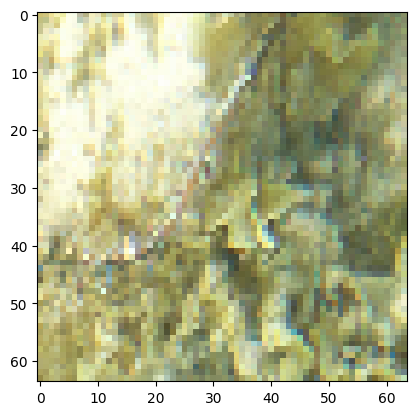

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 1.1840479e-05, 33: 0.99998814}
Example =  12


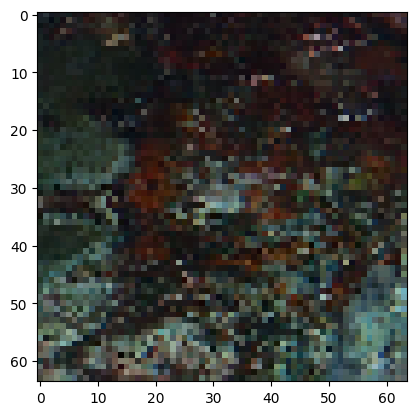

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 0.16657579, 7: 0.8334242}
Example =  13


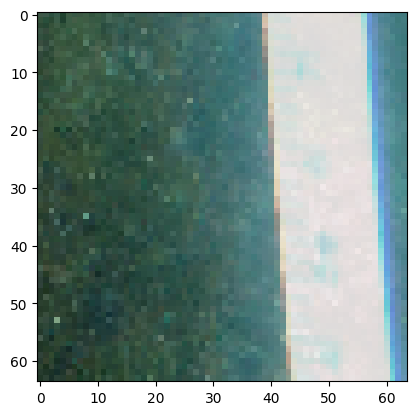

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 0.15007144, 33: 0.84992856}
Example =  14


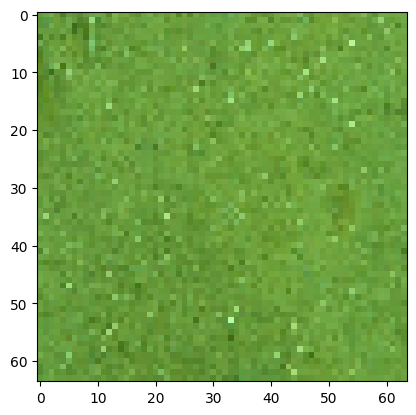

Coarse = {1: 1.0}
Medium = {9: 1.0}
Fine   = {15: 1.0}
Example =  15


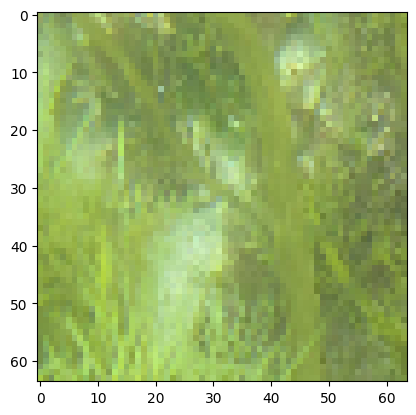

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 1.0}
Example =  16


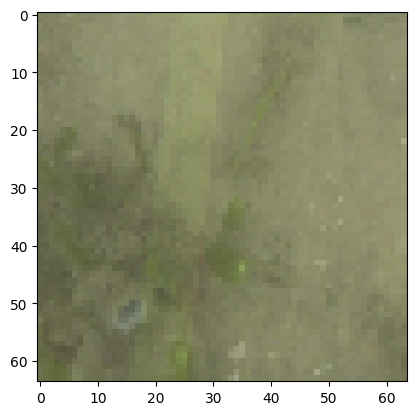

Coarse = {0: 0.10131511, 1: 0.89868486}
Medium = {1: 0.10131511, 9: 0.89868486}
Fine   = {15: 0.89868486, 32: 0.10131511}
Example =  17


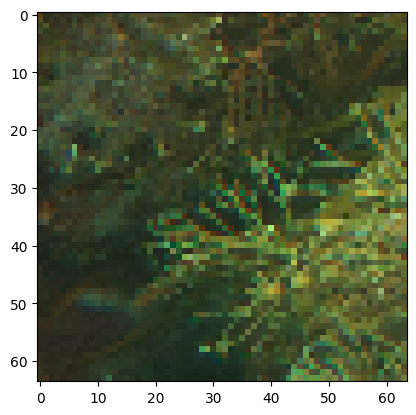

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 1.257658e-05, 33: 0.9999874}
Example =  18


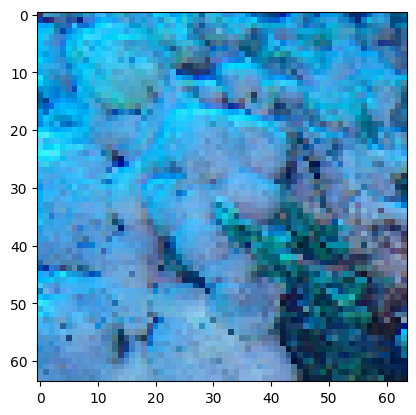

Coarse = {0: 0.9991129, 1: 0.00088709104}
Medium = {1: 0.9991129, 9: 0.00088709104}
Fine   = {14: 0.00088709104, 32: 0.9991129}
Example =  19


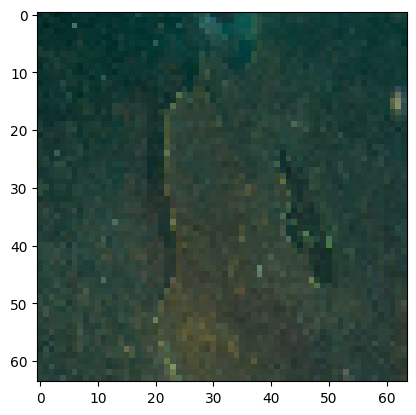

Coarse = {0: 1.0}
Medium = {1: 0.95582896, 7: 0.044171035}
Fine   = {32: 0.95582896, 33: 0.044171035}
Example =  20


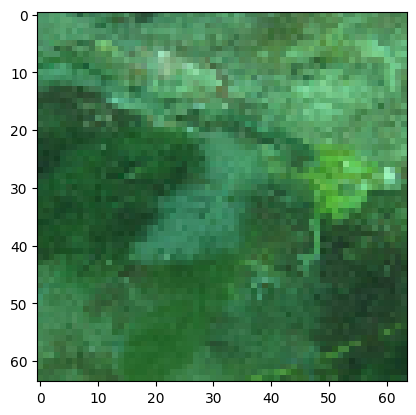

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {1: 0.9733088, 10: 0.026691217}
Example =  21


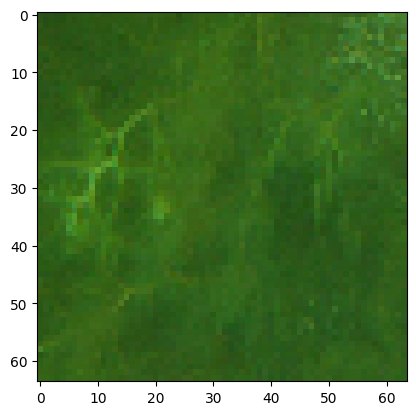

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 0.95731765, 34: 0.042682357}
Example =  22


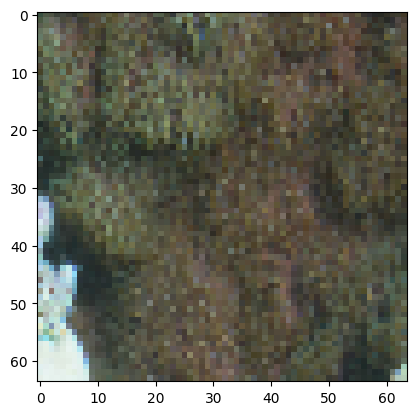

Coarse = {0: 1.0}
Medium = {1: 0.97670215, 7: 0.023297846}
Fine   = {10: 0.023297846, 32: 0.97670215}
Example =  23


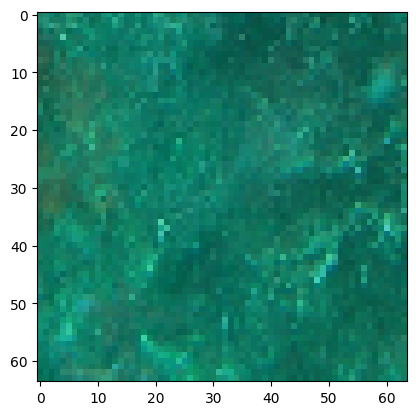

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 0.6368975, 7: 0.3631025}
Example =  24


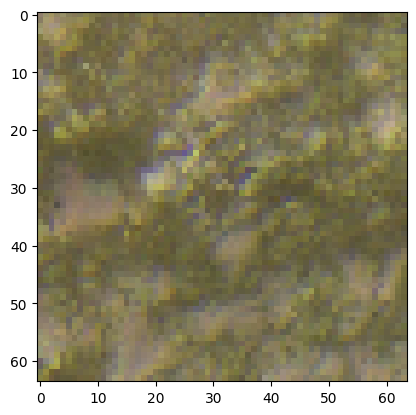

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 1.0}
Example =  25


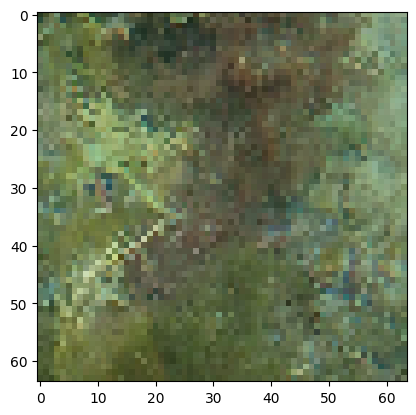

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {4: 0.8206328, 33: 0.17936718}
Example =  26


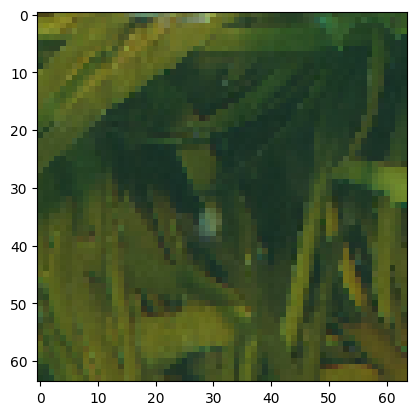

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 1.0}
Example =  27


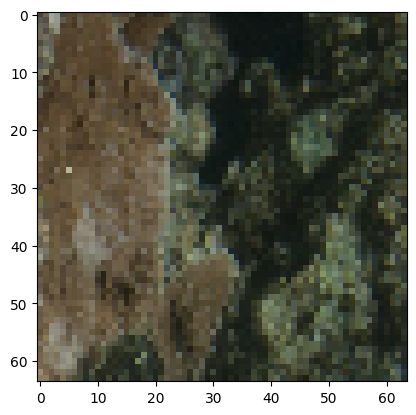

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {10: 0.98896796, 33: 0.011032038}
Example =  28


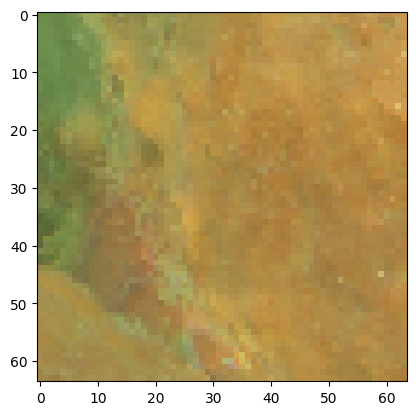

Coarse = {0: 1.0}
Medium = {0: 1.0}
Fine   = {28: 0.21967185, 30: 0.78032815}
Example =  29


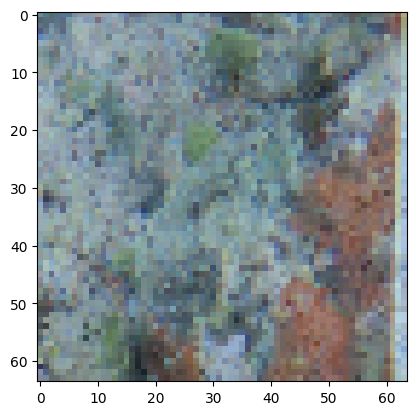

Coarse = {0: 0.57430494, 1: 0.42569506}
Medium = {7: 0.57430494, 9: 0.42569506}
Fine   = {8: 0.57430494, 11: 0.42569506}
Example =  30


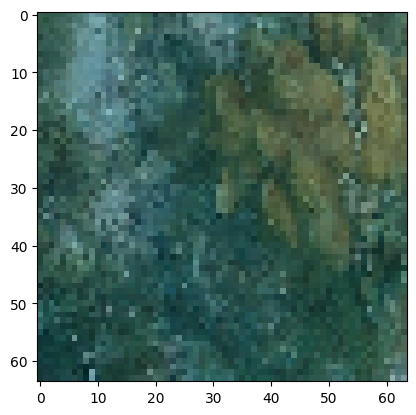

Coarse = {0: 1.0}
Medium = {1: 0.6801064, 7: 0.31989363}
Fine   = {10: 0.31989363, 32: 0.6801064}
Example =  31


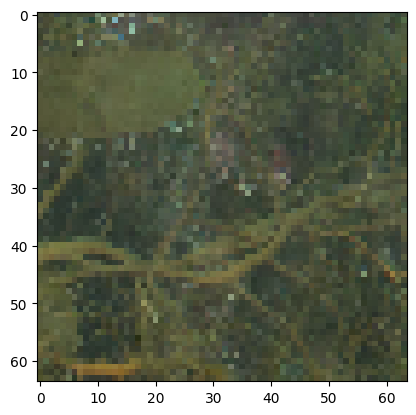

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 1.0}
Example =  32


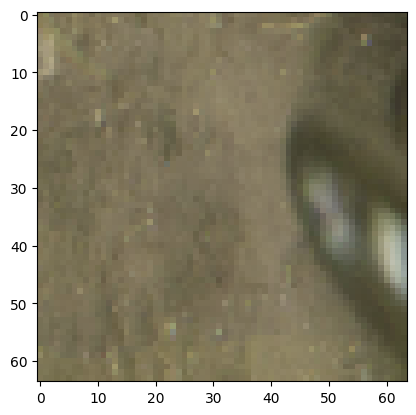

Coarse = {0: 0.15119998, 1: 0.8488}
Medium = {7: 0.15119998, 9: 0.8488}
Fine   = {15: 0.8488, 33: 0.15119998}
Example =  33


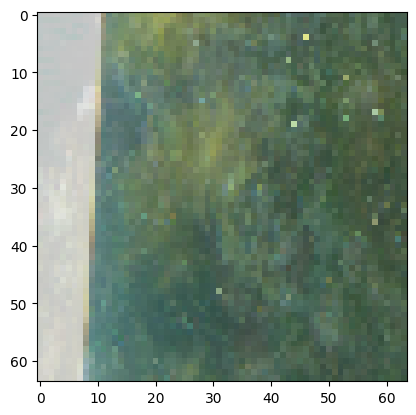

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 0.23543155, 33: 0.76456845}
Example =  34


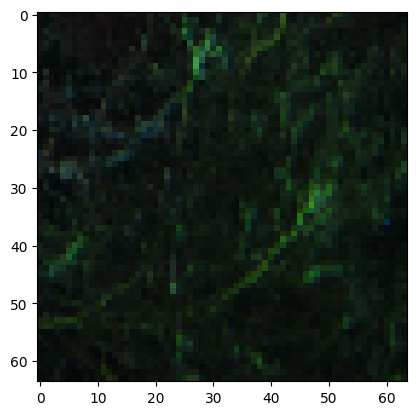

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 2.3841858e-07, 33: 0.99999976}
Example =  35


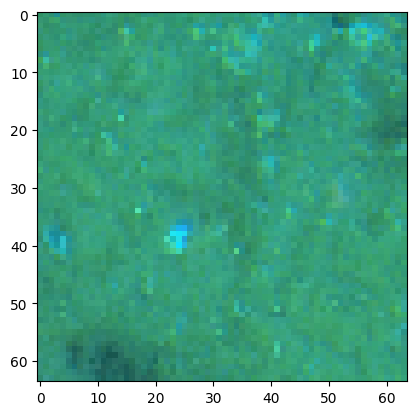

Coarse = {0: 0.00023370377, 1: 0.9997663}
Medium = {6: 0.00023370377, 9: 0.9997663}
Fine   = {15: 0.9997663, 25: 0.00023370377}
Example =  36


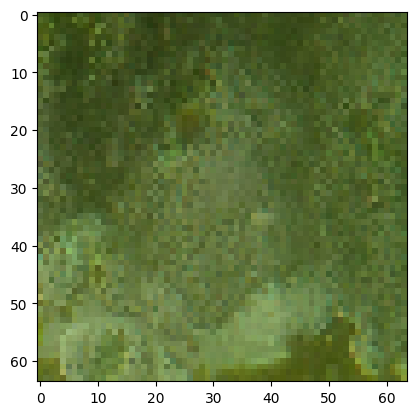

Coarse = {0: 1.0}
Medium = {7: 0.0030918717, 8: 0.9969081}
Fine   = {23: 0.9969081, 36: 0.0030918717}
Example =  37


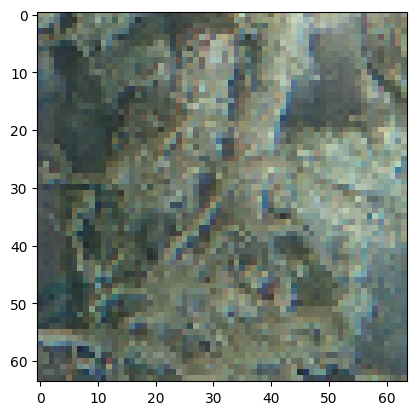

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {10: 0.18389939, 33: 0.8161006}
Example =  38


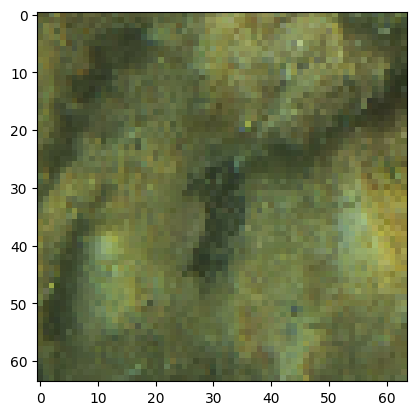

Coarse = {0: 1.0}
Medium = {3: 0.9998738, 7: 0.00012618303}
Fine   = {26: 0.9998738, 33: 0.00012618303}
Example =  39


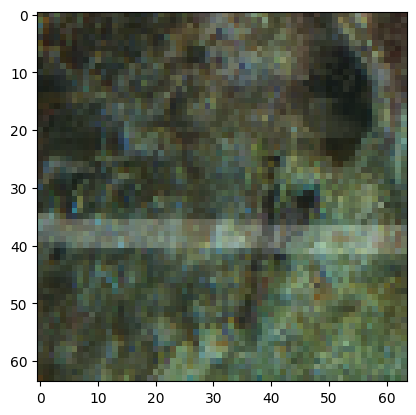

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {10: 0.73975706, 33: 0.26024294}
Example =  40


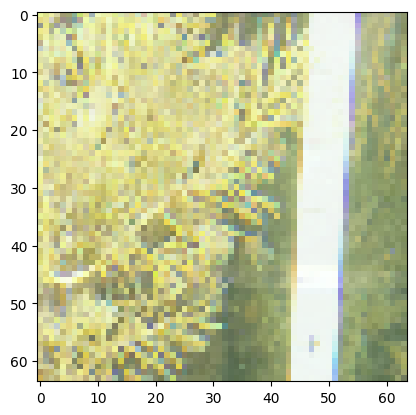

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 0.92892, 36: 0.07108002}
Example =  41


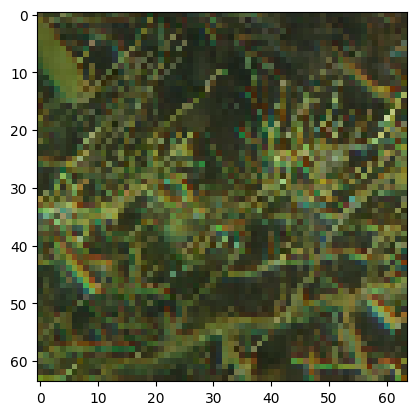

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 0.9548776, 36: 0.045122404}
Example =  42


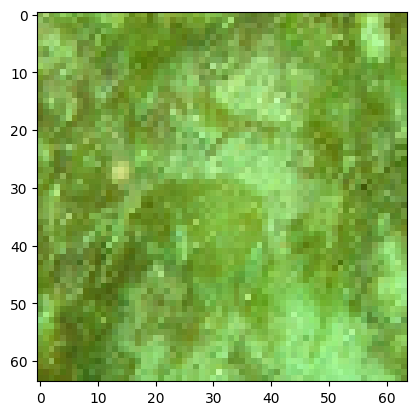

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 0.99998444, 33: 1.5556812e-05}
Example =  43


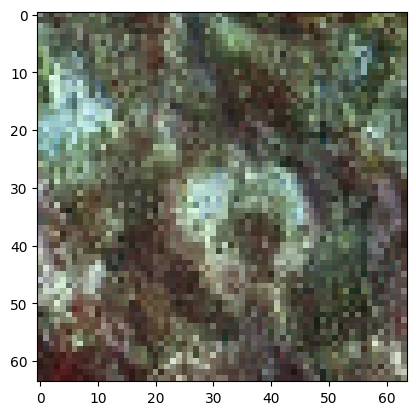

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 0.98876494, 33: 0.011235086}
Example =  44


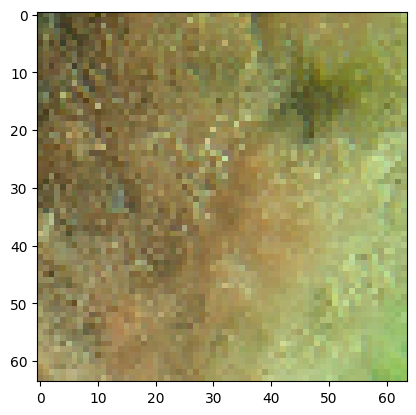

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 6.562025e-10, 34: 1.0}
Example =  45


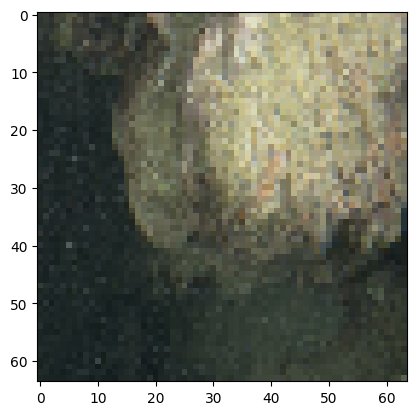

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 7.8082085e-06, 10: 0.9999922}
Example =  46


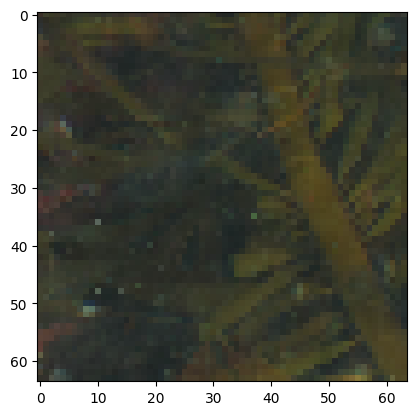

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {33: 1.0}
Example =  47


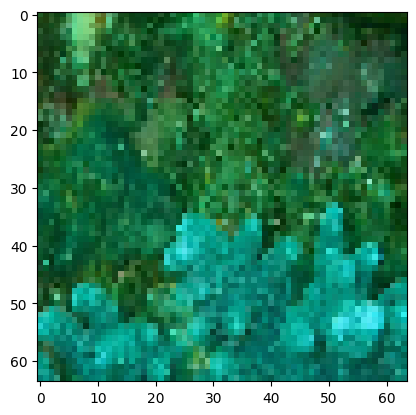

Coarse = {0: 1.0}
Medium = {0: 0.9723138, 7: 0.027686173}
Fine   = {28: 0.9723138, 33: 0.027686173}
Example =  48


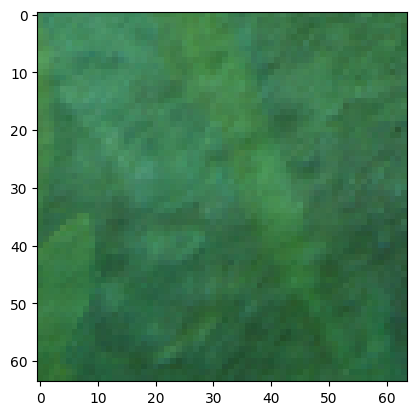

Coarse = {0: 0.47955358, 1: 0.5204464}
Medium = {7: 0.47955358, 9: 0.5204464}
Fine   = {10: 0.47955358, 14: 0.5204464}
Example =  49


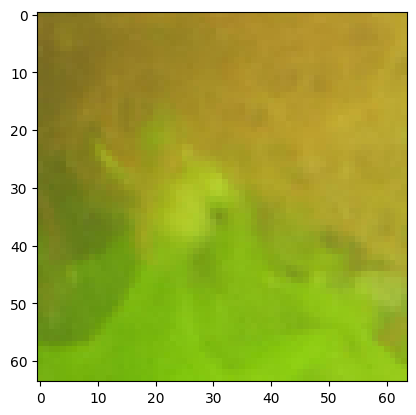

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 0.0077190995, 2: 0.9922809}
Example =  50


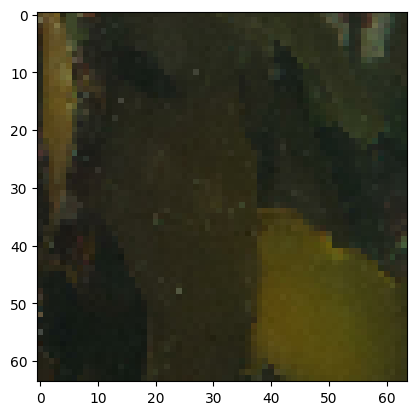

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {7: 6.221463e-05, 33: 0.9999378}
Example =  51


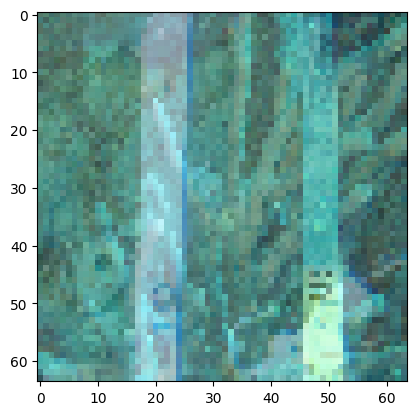

Coarse = {0: 0.46520254, 1: 0.53479743}
Medium = {1: 0.46520254, 9: 0.53479743}
Fine   = {15: 0.53479743, 32: 0.46520254}
Example =  52


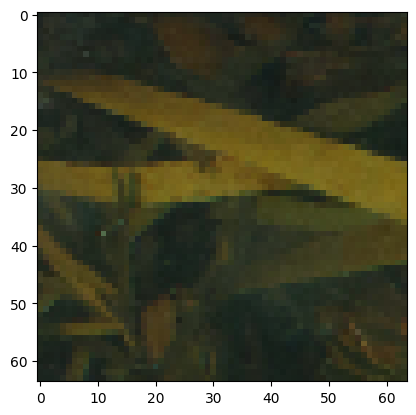

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {10: 0.036582053, 33: 0.96341795}
Example =  53


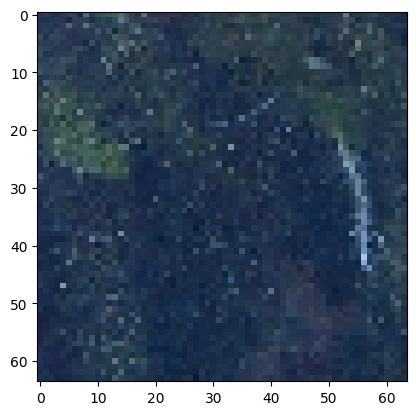

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {1: 0.85307276, 10: 0.14692724}
Example =  54


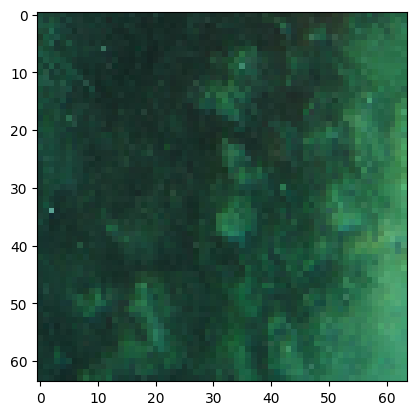

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {4: 0.050712705, 10: 0.9492873}
Example =  55


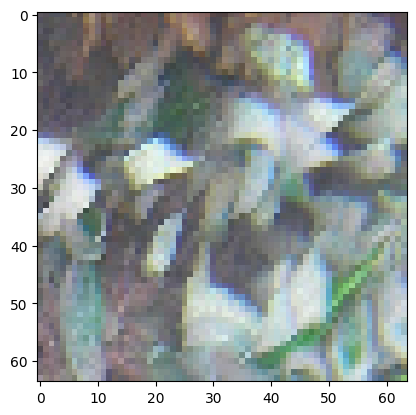

Coarse = {0: 1.0}
Medium = {6: 0.999566, 7: 0.00043398142}
Fine   = {25: 0.999566, 33: 0.00043398142}
Example =  56


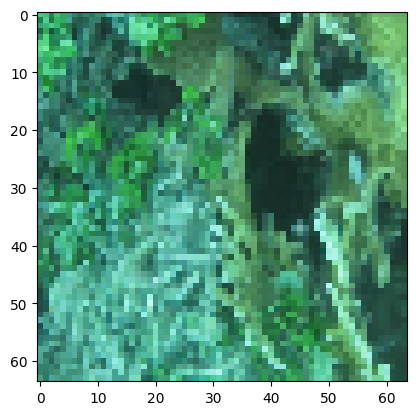

Coarse = {0: 1.0}
Medium = {0: 0.05020356, 1: 0.94979644}
Fine   = {28: 0.05020356, 32: 0.94979644}
Example =  57


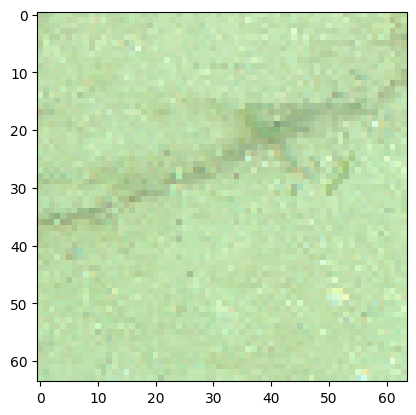

Coarse = {0: 0.0037142038, 1: 0.9962858}
Medium = {7: 0.0037142038, 9: 0.9962858}
Fine   = {15: 0.9962858, 33: 0.0037142038}
Example =  58


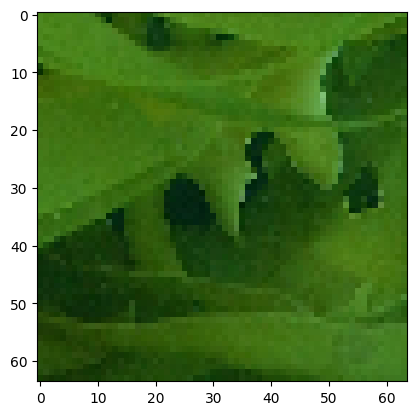

Coarse = {0: 1.0}
Medium = {1: 0.030551255, 7: 0.96944875}
Fine   = {21: 0.030551255, 33: 0.96944875}
Example =  59


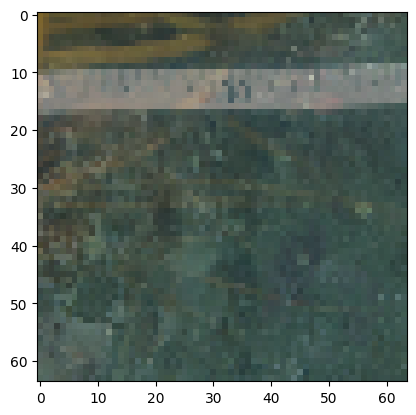

Coarse = {0: 0.5664652, 1: 0.4335348}
Medium = {7: 0.5664652, 9: 0.4335348}
Fine   = {15: 0.4335348, 33: 0.5664652}
Example =  60


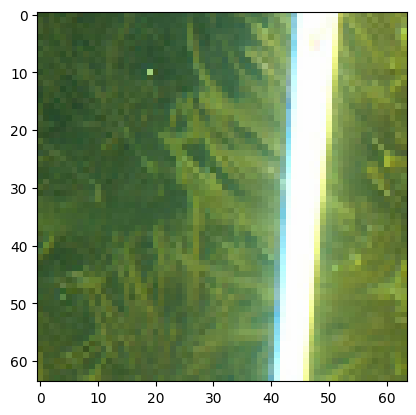

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 9.853791e-06, 33: 0.99999017}
Example =  61


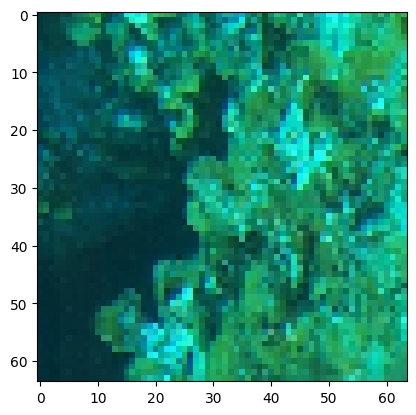

Coarse = {0: 1.0}
Medium = {7: 1.0}
Fine   = {0: 0.97072816, 7: 0.029271824}
Example =  62


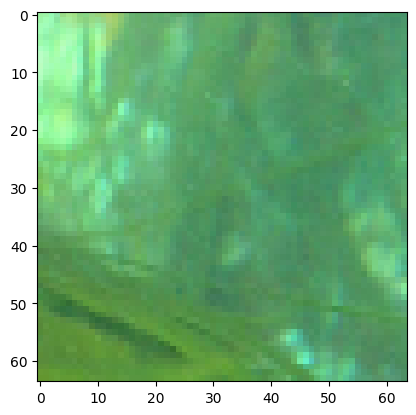

Coarse = {0: 1.0}
Medium = {0: 0.004262036, 7: 0.99573797}
Fine   = {31: 0.004262036, 33: 0.99573797}
Example =  63


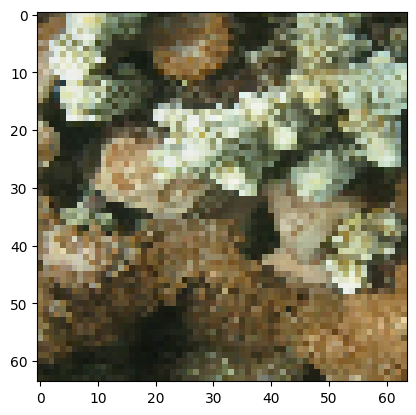

Coarse = {0: 1.0}
Medium = {1: 0.92608505, 7: 0.073914945}
Fine   = {32: 0.92608505, 33: 0.073914945}


In [7]:
for x,y in dataset.train_dataset.take(1):
    for i in range(len(x)):
        print('Example = ', i)
        plt.imshow(x[i])
        plt.show()
        print('Coarse =', {k:v for k,v in enumerate(y[0][i].numpy()) if v != 0}) # coarse lables
        print('Medium =', {k:v for k,v in enumerate(y[1][i].numpy()) if v != 0}) # medium lables
        print('Fine   =', {k:v for k,v in enumerate(y[2][i].numpy()) if v != 0}) # fine lables

In [8]:
for x,y in dataset.train_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [9]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [10]:
coarse_class, medium_class, fine_class = dataset.num_classes

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [11]:
Matrix_coarse_to_medium_OneHot = dataset.Matrix_coarse_to_medium_OneHot
Matrix_medium_to_fine_OneHot = dataset.Matrix_medium_to_fine_OneHot

In [12]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [13]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = coarse_class, 
                                      no_medium_class = medium_class, 
                                      no_fine_class   = fine_class,
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 16, 
                                      SCap_m_dims     = 32, 
                                      SCap_c_dims     = 64)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = medium_class, 
                              number_of_classes_f = fine_class, 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [14]:
model = get_compiled_model()

In [15]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 10)          0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 38)           0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 10)           0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 10)          0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 10)           0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 2)           0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

## Training Pipeline Alignment

In [16]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = dataset.train_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = dataset.val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100


2023-04-13 11:21:39.801976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-04-13 11:21:46.155809: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-13 11:21:46.306859: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] RESOURCE_EXHAUSTED: /tmp/tempfile-luthin-7c88ddac-203387-5f92d8c4dcae4; No space left on device
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1848/1848 [==============================] - ETA: 0s - loss: 0.1776 - prediction_coarse_accuracy: 0.8567 - prediction_medium_accuracy: 0.7047 - prediction_fine_accuracy: 0.3678
  • Coarse Accuracy = 85.67% | Val_Accuracy = 85.77% | LossWeight = 0.26 
  • Medium Accuracy = 70.47% | Val_Accuracy = 71.34% | LossWeight = 0.45 
  • Fine   Accuracy = 36.78% | Val_Accuracy = 38.25% | LossWeight = 0.29 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.38253, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 410s 202ms/step - loss: 0.1776 - prediction_coarse_accuracy: 0.8567 - prediction_medium_accuracy: 0.7047 - prediction_fine_accuracy: 0.3678 - val_loss: 0.1702 - val_prediction_coarse_accuracy: 0.8577 - val_prediction_medium_accuracy: 0.7134 - val_prediction_fine_accuracy: 0.3825 - lr: 0.0010
Epoch 2/100


2023-04-13 11:28:54.947986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3344 of 6400
2023-04-13 11:28:59.655674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.1404 - prediction_coarse_accuracy: 0.8593 - prediction_medium_accuracy: 0.7105 - prediction_fine_accuracy: 0.3929
  • Coarse Accuracy = 85.93% | Val_Accuracy = 85.84% | LossWeight = 0.26 
  • Medium Accuracy = 71.05% | Val_Accuracy = 70.77% | LossWeight = 0.45 
  • Fine   Accuracy = 39.29% | Val_Accuracy = 38.60% | LossWeight = 0.28 

Epoch 2: val_prediction_fine_accuracy improved from 0.38253 to 0.38600, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 509s 265ms/step - loss: 0.1404 - prediction_coarse_accuracy: 0.8593 - prediction_medium_accuracy: 0.7105 - prediction_fine_accuracy: 0.3929 - val_loss: 0.1479 - val_prediction_coarse_accuracy: 0.8584 - val_prediction_medium_accuracy: 0.7077 - val_prediction_fine_accuracy: 0.3860 - lr: 0.0010
Epoch 3/100


2023-04-13 11:37:24.505278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6195 of 6400
2023-04-13 11:37:25.052639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.1357 - prediction_coarse_accuracy: 0.8641 - prediction_medium_accuracy: 0.7189 - prediction_fine_accuracy: 0.4100
  • Coarse Accuracy = 86.41% | Val_Accuracy = 86.45% | LossWeight = 0.26 
  • Medium Accuracy = 71.89% | Val_Accuracy = 71.84% | LossWeight = 0.45 
  • Fine   Accuracy = 41.00% | Val_Accuracy = 40.80% | LossWeight = 0.28 

Epoch 3: val_prediction_fine_accuracy improved from 0.38600 to 0.40801, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 421s 219ms/step - loss: 0.1357 - prediction_coarse_accuracy: 0.8641 - prediction_medium_accuracy: 0.7189 - prediction_fine_accuracy: 0.4100 - val_loss: 0.1335 - val_prediction_coarse_accuracy: 0.8645 - val_prediction_medium_accuracy: 0.7184 - val_prediction_fine_accuracy: 0.4080 - lr: 0.0010
Epoch 4/100
1848/1848 [==============================] - ETA: 0s - loss: 0.1297 - prediction_coarse_accuracy: 0.8702

2023-04-13 11:52:29.661114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3443 of 6400
2023-04-13 11:52:37.802849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.1238 - prediction_coarse_accuracy: 0.8777 - prediction_medium_accuracy: 0.7416 - prediction_fine_accuracy: 0.4555
  • Coarse Accuracy = 87.77% | Val_Accuracy = 87.62% | LossWeight = 0.26 
  • Medium Accuracy = 74.16% | Val_Accuracy = 74.25% | LossWeight = 0.45 
  • Fine   Accuracy = 45.55% | Val_Accuracy = 46.87% | LossWeight = 0.29 

Epoch 5: val_prediction_fine_accuracy improved from 0.44267 to 0.46866, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 275s 137ms/step - loss: 0.1238 - prediction_coarse_accuracy: 0.8777 - prediction_medium_accuracy: 0.7416 - prediction_fine_accuracy: 0.4555 - val_loss: 0.1206 - val_prediction_coarse_accuracy: 0.8762 - val_prediction_medium_accuracy: 0.7425 - val_prediction_fine_accuracy: 0.4687 - lr: 0.0010
Epoch 6/100
1848/1848 [==============================] - ETA: 0s - loss: 0.1191 - prediction_coarse_accuracy: 0.8818

2023-04-13 12:23:46.304107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2768 of 6400
2023-04-13 12:23:56.334413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5301 of 6400
2023-04-13 12:23:59.336279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0948 - prediction_coarse_accuracy: 0.9169 - prediction_medium_accuracy: 0.8216 - prediction_fine_accuracy: 0.5641
  • Coarse Accuracy = 91.69% | Val_Accuracy = 90.21% | LossWeight = 0.24 
  • Medium Accuracy = 82.16% | Val_Accuracy = 78.76% | LossWeight = 0.44 
  • Fine   Accuracy = 56.41% | Val_Accuracy = 54.79% | LossWeight = 0.32 

Epoch 13: val_prediction_fine_accuracy improved from 0.53259 to 0.54790, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 436s 220ms/step - loss: 0.0948 - prediction_coarse_accuracy: 0.9169 - prediction_medium_accuracy: 0.8216 - prediction_fine_accuracy: 0.5641 - val_loss: 0.1007 - val_prediction_coarse_accuracy: 0.9021 - val_prediction_medium_accuracy: 0.7876 - val_prediction_fine_accuracy: 0.5479 - lr: 8.5737e-04
Epoch 14/100


2023-04-13 12:31:02.860137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2708 of 6400
2023-04-13 12:31:12.835393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5592 of 6400
2023-04-13 12:31:15.101999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0907 - prediction_coarse_accuracy: 0.9237 - prediction_medium_accuracy: 0.8333 - prediction_fine_accuracy: 0.5742
  • Coarse Accuracy = 92.37% | Val_Accuracy = 89.29% | LossWeight = 0.24 
  • Medium Accuracy = 83.33% | Val_Accuracy = 78.64% | LossWeight = 0.43 
  • Fine   Accuracy = 57.42% | Val_Accuracy = 55.04% | LossWeight = 0.33 

Epoch 14: val_prediction_fine_accuracy improved from 0.54790 to 0.55044, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 262s 127ms/step - loss: 0.0907 - prediction_coarse_accuracy: 0.9237 - prediction_medium_accuracy: 0.8333 - prediction_fine_accuracy: 0.5742 - val_loss: 0.0990 - val_prediction_coarse_accuracy: 0.8929 - val_prediction_medium_accuracy: 0.7864 - val_prediction_fine_accuracy: 0.5504 - lr: 8.1451e-04
Epoch 15/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0861 - prediction_coarse_accuracy: 

2023-04-13 12:57:25.082947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3069 of 6400
2023-04-13 12:57:32.225928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0673 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.8970 - prediction_fine_accuracy: 0.6366
  • Coarse Accuracy = 96.04% | Val_Accuracy = 89.55% | LossWeight = 0.18 
  • Medium Accuracy = 89.70% | Val_Accuracy = 78.75% | LossWeight = 0.40 
  • Fine   Accuracy = 63.66% | Val_Accuracy = 56.40% | LossWeight = 0.42 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.56756
1848/1848 [==============================] - 501s 258ms/step - loss: 0.0673 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.8970 - prediction_fine_accuracy: 0.6366 - val_loss: 0.0970 - val_prediction_coarse_accuracy: 0.8955 - val_prediction_medium_accuracy: 0.7875 - val_prediction_fine_accuracy: 0.5640 - lr: 5.9874e-04
Epoch 21/100


2023-04-13 13:05:46.518409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2616 of 6400
2023-04-13 13:05:56.478198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5270 of 6400
2023-04-13 13:06:00.582387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0645 - prediction_coarse_accuracy: 0.9639 - prediction_medium_accuracy: 0.9055 - prediction_fine_accuracy: 0.6445
  • Coarse Accuracy = 96.39% | Val_Accuracy = 88.89% | LossWeight = 0.18 
  • Medium Accuracy = 90.55% | Val_Accuracy = 77.82% | LossWeight = 0.39 
  • Fine   Accuracy = 64.45% | Val_Accuracy = 55.75% | LossWeight = 0.44 

Epoch 21: val_prediction_fine_accuracy did not improve from 0.56756
1848/1848 [==============================] - 530s 271ms/step - loss: 0.0645 - prediction_coarse_accuracy: 0.9639 - prediction_medium_accuracy: 0.9055 - prediction_fine_accuracy: 0.6445 - val_loss: 0.1002 - val_prediction_coarse_accuracy: 0.8889 - val_prediction_medium_accuracy: 0.7782 - val_prediction_fine_accuracy: 0.5575 - lr: 5.6880e-04
Epoch 22/100


2023-04-13 13:15:08.599083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2958 of 6400
2023-04-13 13:15:18.613882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6113 of 6400
2023-04-13 13:15:19.281293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0624 - prediction_coarse_accuracy: 0.9664 - prediction_medium_accuracy: 0.9119 - prediction_fine_accuracy: 0.6523
  • Coarse Accuracy = 96.64% | Val_Accuracy = 89.27% | LossWeight = 0.17 
  • Medium Accuracy = 91.19% | Val_Accuracy = 77.43% | LossWeight = 0.38 
  • Fine   Accuracy = 65.23% | Val_Accuracy = 56.13% | LossWeight = 0.45 

Epoch 22: val_prediction_fine_accuracy did not improve from 0.56756
1848/1848 [==============================] - 641s 333ms/step - loss: 0.0624 - prediction_coarse_accuracy: 0.9664 - prediction_medium_accuracy: 0.9119 - prediction_fine_accuracy: 0.6523 - val_loss: 0.1004 - val_prediction_coarse_accuracy: 0.8927 - val_prediction_medium_accuracy: 0.7743 - val_prediction_fine_accuracy: 0.5613 - lr: 5.4036e-04
Epoch 23/100


2023-04-13 13:25:50.189467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2838 of 6400
2023-04-13 13:26:00.226096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5704 of 6400
2023-04-13 13:26:02.497891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0601 - prediction_coarse_accuracy: 0.9688 - prediction_medium_accuracy: 0.9183 - prediction_fine_accuracy: 0.6585
  • Coarse Accuracy = 96.88% | Val_Accuracy = 89.46% | LossWeight = 0.17 
  • Medium Accuracy = 91.83% | Val_Accuracy = 78.27% | LossWeight = 0.37 
  • Fine   Accuracy = 65.85% | Val_Accuracy = 56.17% | LossWeight = 0.46 

Epoch 23: val_prediction_fine_accuracy did not improve from 0.56756
1848/1848 [==============================] - 321s 159ms/step - loss: 0.0601 - prediction_coarse_accuracy: 0.9688 - prediction_medium_accuracy: 0.9183 - prediction_fine_accuracy: 0.6585 - val_loss: 0.0982 - val_prediction_coarse_accuracy: 0.8946 - val_prediction_medium_accuracy: 0.7827 - val_prediction_fine_accuracy: 0.5617 - lr: 5.1334e-04
Epoch 24/100


2023-04-13 13:31:12.314711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4326 of 6400
2023-04-13 13:31:16.985405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0585 - prediction_coarse_accuracy: 0.9698 - prediction_medium_accuracy: 0.9221 - prediction_fine_accuracy: 0.6631
  • Coarse Accuracy = 96.98% | Val_Accuracy = 89.76% | LossWeight = 0.17 
  • Medium Accuracy = 92.21% | Val_Accuracy = 78.97% | LossWeight = 0.36 
  • Fine   Accuracy = 66.31% | Val_Accuracy = 57.12% | LossWeight = 0.47 

Epoch 24: val_prediction_fine_accuracy improved from 0.56756 to 0.57115, saving model to ../../logs/7_Marine_Tree/HD_CapsNet/Mod_3_3/epoch-best.h5
1848/1848 [==============================] - 294s 148ms/step - loss: 0.0585 - prediction_coarse_accuracy: 0.9698 - prediction_medium_accuracy: 0.9221 - prediction_fine_accuracy: 0.6631 - val_loss: 0.0956 - val_prediction_coarse_accuracy: 0.8976 - val_prediction_medium_accuracy: 0.7897 - val_prediction_fine_accuracy: 0.5712 - lr: 4.8767e-04
Epoch 25/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0568 - prediction_coarse_accuracy: 

1848/1848 [==============================] - 264s 136ms/step - loss: 0.0485 - prediction_coarse_accuracy: 0.9770 - prediction_medium_accuracy: 0.9484 - prediction_fine_accuracy: 0.7202 - val_loss: 0.0970 - val_prediction_coarse_accuracy: 0.8984 - val_prediction_medium_accuracy: 0.7870 - val_prediction_fine_accuracy: 0.5733 - lr: 2.9199e-04
Epoch 35/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0479 - prediction_coarse_accuracy: 0.9771 - prediction_medium_accuracy: 0.9487 - prediction_fine_accuracy: 0.7251
  • Coarse Accuracy = 97.71% | Val_Accuracy = 89.95% | LossWeight = 0.17 
  • Medium Accuracy = 94.87% | Val_Accuracy = 78.61% | LossWeight = 0.32 
  • Fine   Accuracy = 72.51% | Val_Accuracy = 57.34% | LossWeight = 0.51 

Epoch 35: val_prediction_fine_accuracy did not improve from 0.57568
1848/1848 [==============================] - 253s 129ms/step - loss: 0.0479 - prediction_coarse_accuracy: 0.9771 - prediction_medium_accuracy: 0.9487 - prediction_fine_accuracy:

2023-04-13 15:33:27.442927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3058 of 6400
2023-04-13 15:33:37.488953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6009 of 6400
2023-04-13 15:33:38.179649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0424 - prediction_coarse_accuracy: 0.9794 - prediction_medium_accuracy: 0.9581 - prediction_fine_accuracy: 0.7887
  • Coarse Accuracy = 97.94% | Val_Accuracy = 89.75% | LossWeight = 0.19 
  • Medium Accuracy = 95.81% | Val_Accuracy = 78.28% | LossWeight = 0.32 
  • Fine   Accuracy = 78.87% | Val_Accuracy = 56.25% | LossWeight = 0.49 

Epoch 50: val_prediction_fine_accuracy did not improve from 0.57568
1848/1848 [==============================] - 307s 153ms/step - loss: 0.0424 - prediction_coarse_accuracy: 0.9794 - prediction_medium_accuracy: 0.9581 - prediction_fine_accuracy: 0.7887 - val_loss: 0.1020 - val_prediction_coarse_accuracy: 0.8975 - val_prediction_medium_accuracy: 0.7828 - val_prediction_fine_accuracy: 0.5625 - lr: 1.2851e-04
Epoch 51/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0418 - prediction_coarse_accuracy: 0.9792 - prediction_medium_accuracy: 0.9588 - prediction_fine_accuracy: 0.7924


1848/1848 [==============================] - 251s 129ms/step - loss: 0.0403 - prediction_coarse_accuracy: 0.9796 - prediction_medium_accuracy: 0.9605 - prediction_fine_accuracy: 0.8137 - val_loss: 0.1012 - val_prediction_coarse_accuracy: 0.8969 - val_prediction_medium_accuracy: 0.7840 - val_prediction_fine_accuracy: 0.5603 - lr: 8.0995e-05
Epoch 60/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0408 - prediction_coarse_accuracy: 0.9794 - prediction_medium_accuracy: 0.9595 - prediction_fine_accuracy: 0.8149
  • Coarse Accuracy = 97.94% | Val_Accuracy = 89.69% | LossWeight = 0.21 
  • Medium Accuracy = 95.95% | Val_Accuracy = 78.43% | LossWeight = 0.34 
  • Fine   Accuracy = 81.49% | Val_Accuracy = 56.41% | LossWeight = 0.46 

Epoch 60: val_prediction_fine_accuracy did not improve from 0.57568
1848/1848 [==============================] - 269s 138ms/step - loss: 0.0408 - prediction_coarse_accuracy: 0.9794 - prediction_medium_accuracy: 0.9595 - prediction_fine_accuracy:

2023-04-13 17:36:32.032492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2834 of 6400
2023-04-13 17:36:42.067357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5893 of 6400
2023-04-13 17:36:43.475715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1848/1848 [==============================] - ETA: 0s - loss: 0.0389 - prediction_coarse_accuracy: 0.9795 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.8377
  • Coarse Accuracy = 97.95% | Val_Accuracy = 89.84% | LossWeight = 0.22 
  • Medium Accuracy = 96.17% | Val_Accuracy = 78.73% | LossWeight = 0.34 
  • Fine   Accuracy = 83.77% | Val_Accuracy = 55.97% | LossWeight = 0.44 

Epoch 77: val_prediction_fine_accuracy did not improve from 0.57568
1848/1848 [==============================] - 342s 170ms/step - loss: 0.0389 - prediction_coarse_accuracy: 0.9795 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.8377 - val_loss: 0.1023 - val_prediction_coarse_accuracy: 0.8984 - val_prediction_medium_accuracy: 0.7873 - val_prediction_fine_accuracy: 0.5597 - lr: 3.2172e-05
Epoch 78/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0391 - prediction_coarse_accuracy: 0.9795 - prediction_medium_accuracy: 0.9609 - prediction_fine_accuracy: 0.8386


1848/1848 [==============================] - 269s 139ms/step - loss: 0.0389 - prediction_coarse_accuracy: 0.9799 - prediction_medium_accuracy: 0.9615 - prediction_fine_accuracy: 0.8431 - val_loss: 0.1033 - val_prediction_coarse_accuracy: 0.8979 - val_prediction_medium_accuracy: 0.7861 - val_prediction_fine_accuracy: 0.5598 - lr: 2.0277e-05
Epoch 87/100
1848/1848 [==============================] - ETA: 0s - loss: 0.0388 - prediction_coarse_accuracy: 0.9797 - prediction_medium_accuracy: 0.9612 - prediction_fine_accuracy: 0.8419
  • Coarse Accuracy = 97.97% | Val_Accuracy = 89.87% | LossWeight = 0.22 
  • Medium Accuracy = 96.12% | Val_Accuracy = 78.77% | LossWeight = 0.35 
  • Fine   Accuracy = 84.19% | Val_Accuracy = 55.93% | LossWeight = 0.43 

Epoch 87: val_prediction_fine_accuracy did not improve from 0.57568
1848/1848 [==============================] - 369s 192ms/step - loss: 0.0388 - prediction_coarse_accuracy: 0.9797 - prediction_medium_accuracy: 0.9612 - prediction_fine_accuracy:

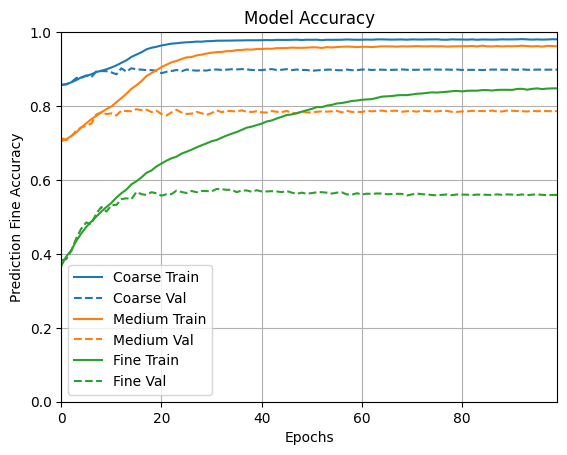

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

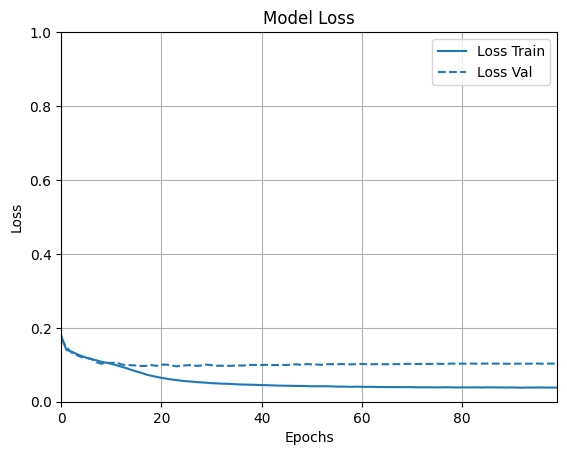

In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)
final_model.load_weights(directory+'/epoch-best.h5')

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [28]:
results = final_model.evaluate(dataset.test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
# model_predictions = final_model.predict(dataset.test_dataset)

419/419 [==============================] - 264s 624ms/step - loss: 0.2124 - prediction_coarse_loss: 0.0744 - prediction_medium_loss: 0.1692 - prediction_fine_loss: 0.3199 - prediction_coarse_accuracy: 0.8988 - prediction_medium_accuracy: 0.7860 - prediction_fine_accuracy: 0.5715
1. loss ==> 0.21237286925315857
2. prediction_coarse_loss ==> 0.07444676011800766
3. prediction_medium_loss ==> 0.1691640168428421
4. prediction_fine_loss ==> 0.31985634565353394
5. prediction_coarse_accuracy ==> 0.8987610936164856
6. prediction_medium_accuracy ==> 0.7859914898872375
7. prediction_fine_accuracy ==> 0.5715351700782776


In [29]:
def predict_from_pipeline(model, dataset):
    y_pred_c = []
    y_pred_m = []
    y_pred_f = []
    
    y_true_c = []
    y_true_m = []
    y_true_f = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        
        y_true_c.extend(y[0].numpy().tolist())
        y_true_m.extend(y[1].numpy().tolist())
        y_true_f.extend(y[2].numpy().tolist())
        
        y_pred_c.extend(batch_pred[0].tolist())
        y_pred_m.extend(batch_pred[1].tolist())
        y_pred_f.extend(batch_pred[2].tolist())
        
    return np.array(y_true_c), np.array(y_true_m), np.array(y_true_f), np.array(y_pred_c), np.array(y_pred_m), np.array(y_pred_f)

In [30]:
y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f = predict_from_pipeline(final_model, dataset.test_dataset)

  • Confusion_Matrix 

  • COARSE LEVEL 
[[22425   655]
 [ 2058  1660]]

  • MEDIUM LEVEL 
[[   79    77     0     0     0     6     5   506     0    70]
 [   44  1148     0     0     0     3     5  1001     0   124]
 [    3     0     0     0     0     0     0    20     0     1]
 [    2     3     0    27     0     3     0    76     0     8]
 [    2     2     0     0     0     0     0    44     0     1]
 [    7    21     0     2     0     5     0    99     0    10]
 [    1     2     0     0     0     0   451   230     0    11]
 [  141   379     0     4     0    11   157 17530     0   740]
 [    0     1     0     0     0     1     0    16     0     1]
 [   37   154     0     2     0     6    23  1673     0  1823]]

  • FINE LEVEL 
[[590  28   4 ...   0  22   5]
 [ 45 254  11 ...   0   2   2]
 [ 41  58  79 ...   0   3   1]
 ...
 [  7  10   1 ...   0   6   0]
 [104  31   7 ...   0  81   1]
 [  3   2   0 ...   0   0 233]]

  • Classification Report 


  • COARSE LEVEL 


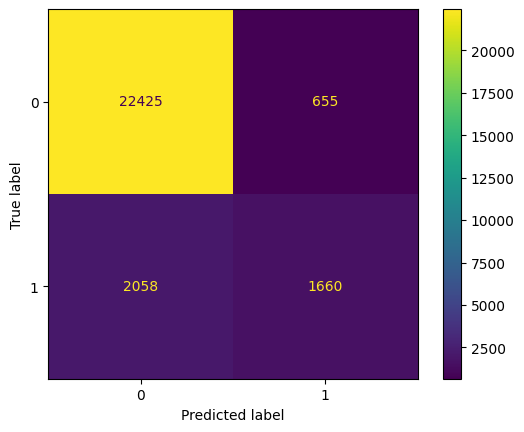

              precision    recall  f1-score   support

           0    0.91594   0.97162   0.94296     23080
           1    0.71706   0.44648   0.55031      3718

    accuracy                        0.89876     26798
   macro avg    0.81650   0.70905   0.74663     26798
weighted avg    0.88835   0.89876   0.88848     26798


  • MEDIUM LEVEL 


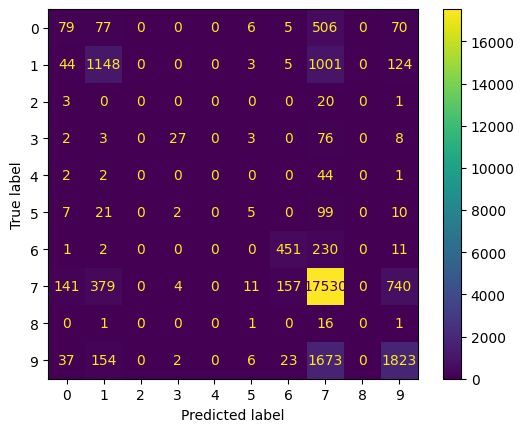

/home/knoor/.conda/envs/tf28_luthin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tf28_luthin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tf28_luthin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

           0    0.25000   0.10633   0.14920       743
           1    0.64242   0.49376   0.55837      2325
           2    0.00000   0.00000   0.00000        24
           3    0.77143   0.22689   0.35065       119
           4    0.00000   0.00000   0.00000        49
           5    0.14286   0.03472   0.05587       144
           6    0.70359   0.64892   0.67515       695
           7    0.82708   0.92448   0.87307     18962
           8    0.00000   0.00000   0.00000        19
           9    0.65364   0.49032   0.56032      3718

    accuracy                        0.78599     26798
   macro avg    0.39910   0.29254   0.32226     26798
weighted avg    0.76103   0.78599   0.76747     26798


  • FINE LEVEL 


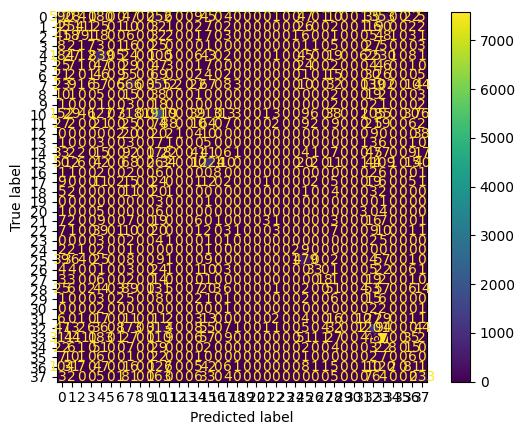

              precision    recall  f1-score   support

           0    0.32507   0.35976   0.34153      1640
           1    0.42617   0.47925   0.45115       530
           2    0.57246   0.25159   0.34956       314
           3    0.21875   0.06604   0.10145       106
           4    0.43562   0.53304   0.47943      1574
           5    0.00000   0.00000   0.00000       244
           6    0.18367   0.03114   0.05325       289
           7    0.32014   0.38399   0.34917      1474
           8    0.00000   0.00000   0.00000        96
           9    0.00000   0.00000   0.00000        30
          10    0.42615   0.57984   0.49126      3294
          11    0.39111   0.20561   0.26953       428
          12    0.33333   0.00943   0.01835       106
          13    0.00000   0.00000   0.00000        31
          14    0.21026   0.07130   0.10649       575
          15    0.61261   0.62385   0.61818      1962
          16    0.61538   0.27586   0.38095        29
          17    0.02000   0

/home/knoor/.conda/envs/tf28_luthin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tf28_luthin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/knoor/.conda/envs/tf28_luthin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [31]:
metrics.lvl_wise_metric([y_true_c, y_true_m, y_true_f],
                        [y_pred_c, y_pred_m, y_pred_f])

In [32]:
h_measurements,consistency,exact_match = metrics.hmeasurements([y_true_c, y_true_m, y_true_f],
                                                               [y_pred_c, y_pred_m, y_pred_f],
                                                               dataset.get_tree())
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7501946662686269 
Hierarchical Recall = 0.760442321566286 
Hierarchical F1-Score = 0.7543682186659274 
Consistency =  0.9447346816926636 
Exact Match =  0.5559370102246436
